# Calibrating a Network Using Mercury Intrusion Data

Mercury intrusion porosimetry (MIP) is a common technique in the study of porous media used to determine the pore size distribution of a porous material. There are two reasons why one would want to fit a PNM to MIP data.

The first reason is to more accurately obtain pore size distributiosn from MIP data.  MIP data is universally interpreted using a 'bundle of tubes' model, which neglects the shielding effect that occurs when large pore bodies are 'shielded' behind smaller ones.  A more nuanced interpretation of MIP data requires using a pore network model to fit the data, then obtaining the pore and throat size distribution of the model. This is not usually done because it is quite a bit more difficult, and the additional accuracy is not necessarily justified. 

The second reason is that often we wish to generate a cubic pore network that is representative of a specific material so that we can then perform additional simulations using the network.  This is called network calibration.  Calibration can also involve fitting of permeability and formation factor data as well, since successfully fitting more metrics means a better calibration. 

In this example, we will show how OpenPNM can be used to simulate mercury intrusion and estimate the pore size distribution of a network, and we'll compare this experimental values, and iterate until they match. 

## Import Packages

In [18]:
import numpy as np
import openpnm as op
import pandas as pd
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import scipy.stats as spst

op.visualization.set_mpl_style()
np.random.seed(10)
ws = op.Workspace()
ws.settings["loglevel"] = 40
np.set_printoptions(precision=5)

## Import Data for Fibrous Gas Diffusion Layer

Let's import some data for SGL10AA, a classic fibrous material use in fuel cells.  First, an SEM image:

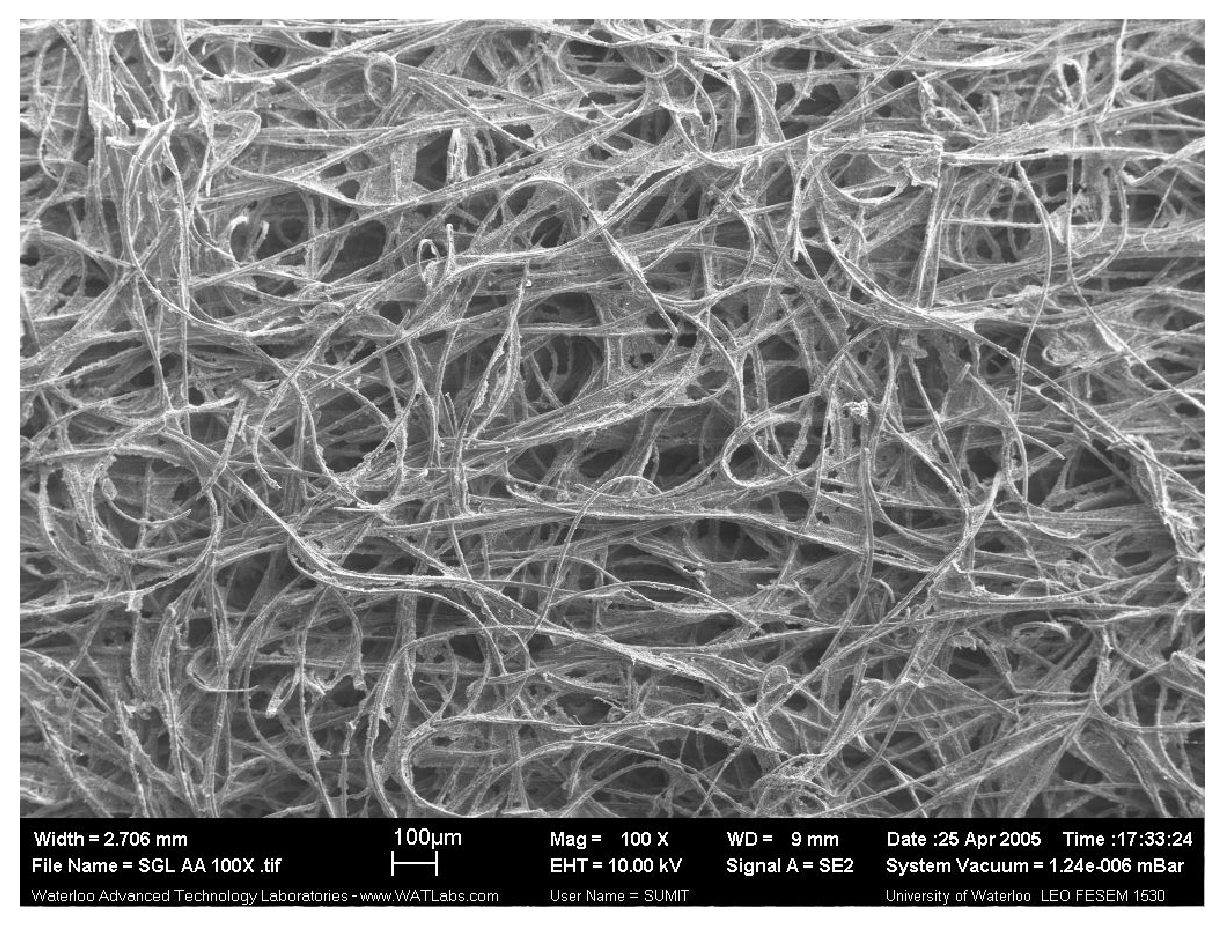

In [9]:
im = imageio.imread('10AA 100X .jpg')
plt.imshow(im)
plt.axis(False);

A few things to note here.  The pores are in the range of 100 um in diameter, and they are basically 100 um apart since the solid structure is defined by the fibers which are very thin (<10 um).  We can also see some 'cruft' around the fibers, which is a carbon binder which was added to keep the structure together.  This has some porosity a but we'll neglect this here, which also means we won't try to match the higher pressure regions of the MIP data.

Now let's import some MIP data for this sample:

In [10]:
df = pd.read_csv('SGL10AA.csv')
df

,Pc [Pa],s
0,5818.109071,0.000000
1,5961.411571,0.001959
2,6116.176893,0.003906
3,6574.751786,0.005865
4,7491.887786,0.017581
...,...,...
148,336206.482500,1.000000
149,338252.847700,1.000000
150,340264.824500,1.000000
151,342322.659400,1.000000


We have 152 pressure points, and the mercury volume has already been normalized by the porosity, which was 91% in this case.

## Network

We may want to use a large network for some future simulations, but for the sake of the fitting process we can use a relatively small network to get the parameters.  Here we will use use a simple cubic network with 15 pores per side and a spacing of 100 um.  Note that we *can and will* adjust this spacing if it let's us match the data more closely.

In [16]:
pn = op.network.Cubic(shape=[15, 15, 15], spacing=100e-6)
print(pn)


══════════════════════════════════════════════════════════════════════════════
net : <openpnm.network.Cubic at 0x1f528dc5d10>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  2  pore.coords                                                   3375 / 3375
  3  throat.conns                                                  9450 / 9450
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Labels                                                 Assigned Locations
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  2  pore.surface                                                         1178
  3  throat.surface                                                       2352
  4  pore.left                                                             225
  5 

## Add Geometrical Properties

The network object only contains topological and spatial information.  We need to assign some pore and throat sizes.  Since one of the objectives of this tutorial is to shine some light on the use of pore-scale models and how to customize them, we will *not* use the convenient pre-packages model collections, but instead add all the models we need by hand.  Let's start by assigning sizes to the pore bodies:

### Pore Sizes

It is possible to produce sizes directly from a statistical distribution, like ``scipy.stats.weibull_min.rvs(<args>)``, however, we are going to do it the "hard way" since this will help us later.  We'll start by assigning random seed values between 0 and 1, then using these to do a reverse lookup of th esizes from our desired distribution:

In [17]:
np.random.seed(0)  # Set the state of the random number generator to "0"
pn['pore.seed'] = np.random.rand(pn.Np)

Now let's define a statistical distribution. The Weibull distribution is common since it has mostly small pore and a long tail of a few large pores, which is typical of many porous materials.

In [46]:
dst = spst.weibull_min(c=1.8, loc=5e-6, scale=50e-6)

Let's quickly look at some values from this distribution to see if the parameters we chose are a decent starting point:

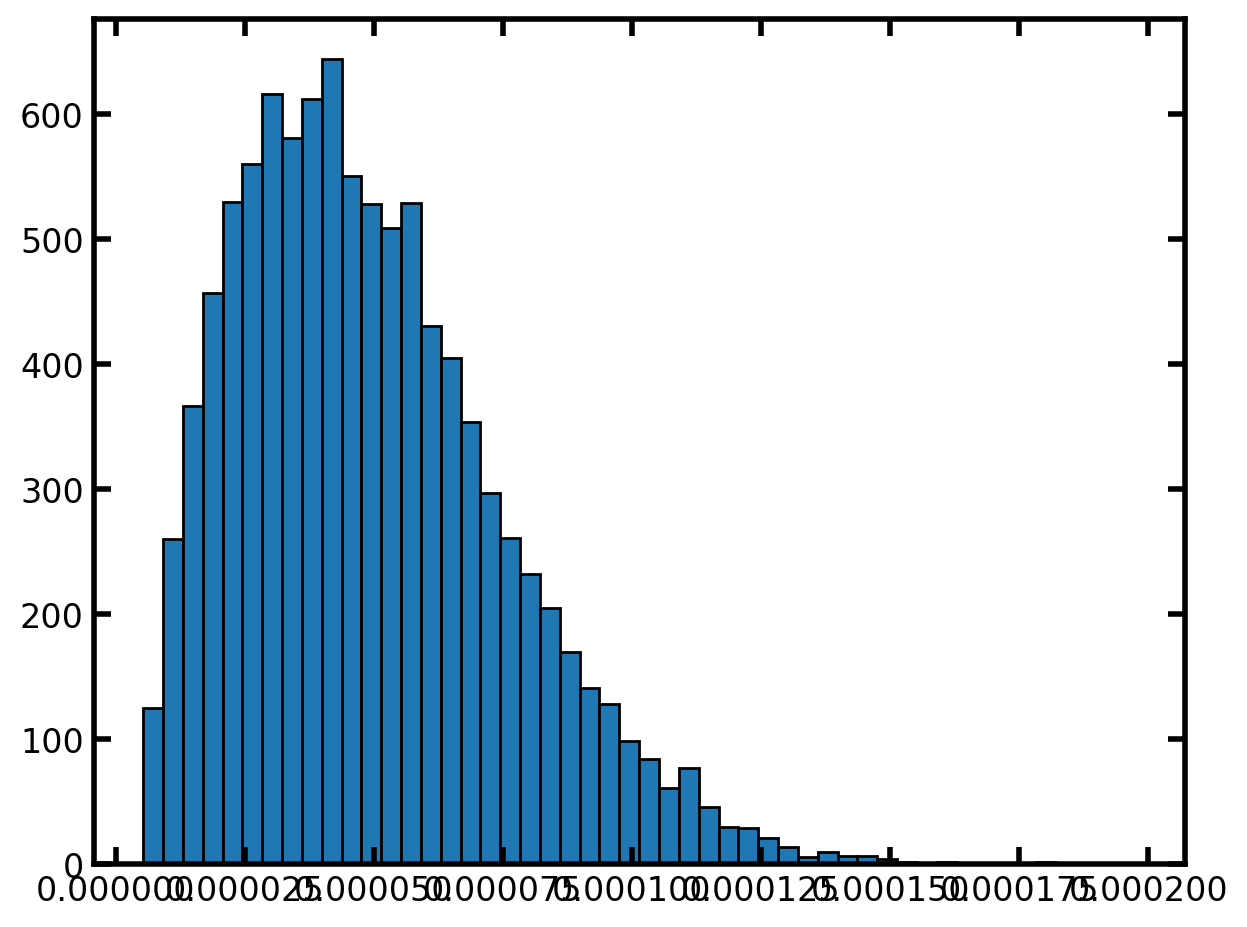

In [47]:
plt.hist(dst.rvs(10000), bins=50, edgecolor='k');

This looks pretty good.  The minimum value (`loc`) was set to 5um, and the `scale` of 50um positions the distribution well within our expected range.  Lastly, the `c` value controls the skew, which has created a slighly elongated tail, but nothing too  extreme.  However, note that a pore diameter of 175um is quite a bit larger than the pore spacing we used (100um) so this will lead to overlap of pores, which can be problematic. Nonetheless, this is a decent enough starting point.

Before moving on, let's first examine how we can produce random values given seed values between 0 and 1.  Below is a plot of the cumulative probability distribution (`cdf`). The y-axis is the `pn['pore.seed']` values, and the x-axis is the pore size value.  The `'pore.seed'` values are chosen at random between 0 and 1, and the size values can be found by doing a reverse "look-up", shown by the red lines.

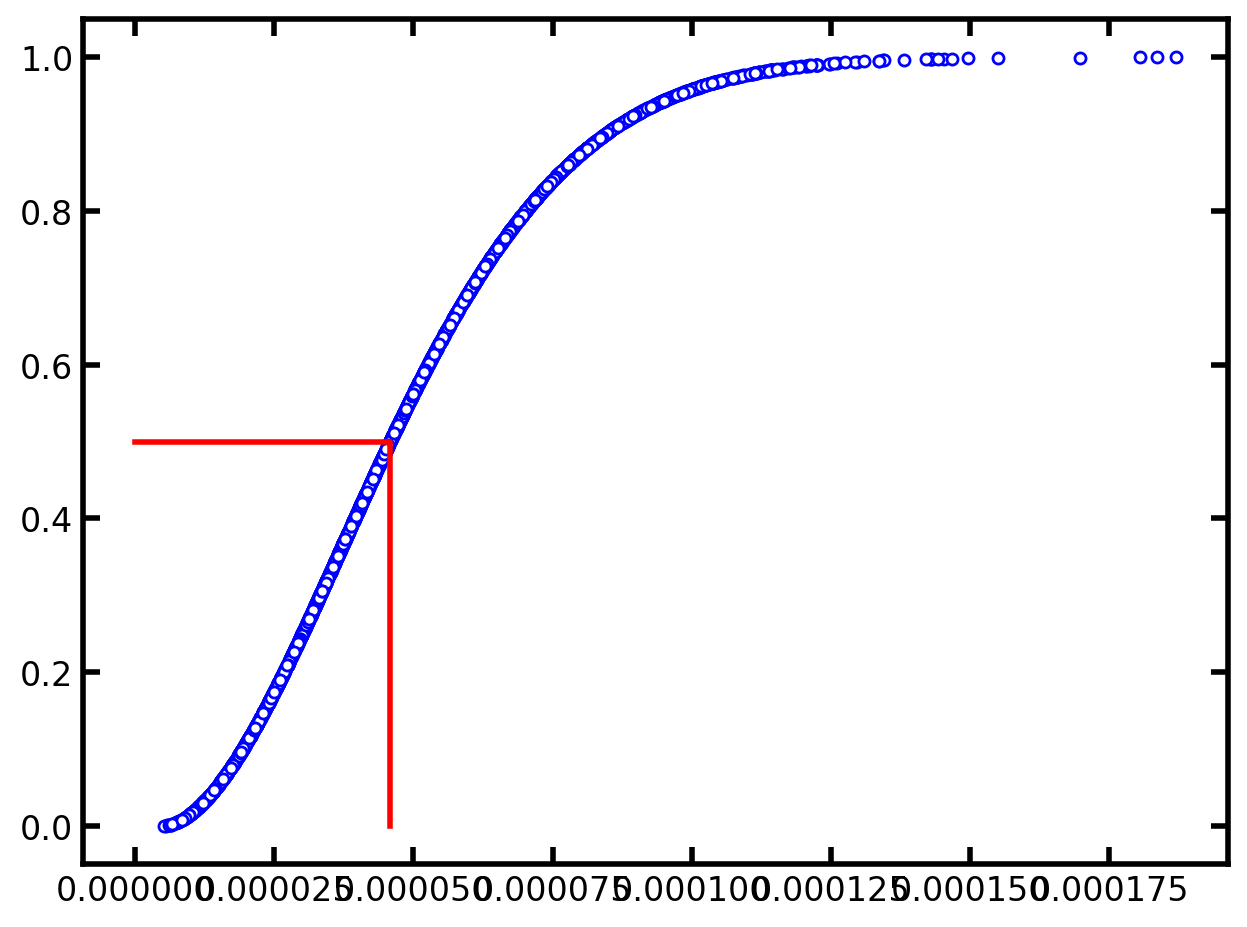

In [55]:
plt.plot(dst.ppf(pn['pore.seed']), pn['pore.seed'], 'b.')
plt.plot([0, dst.ppf(0.5), dst.ppf(0.5)], [0.5, 0.5, 0.0], 'r-');

We can now use this model to generate our pore sizes for the network.  We can do this easy way or the right way.  First the easy way, just assigning values to the network directly:

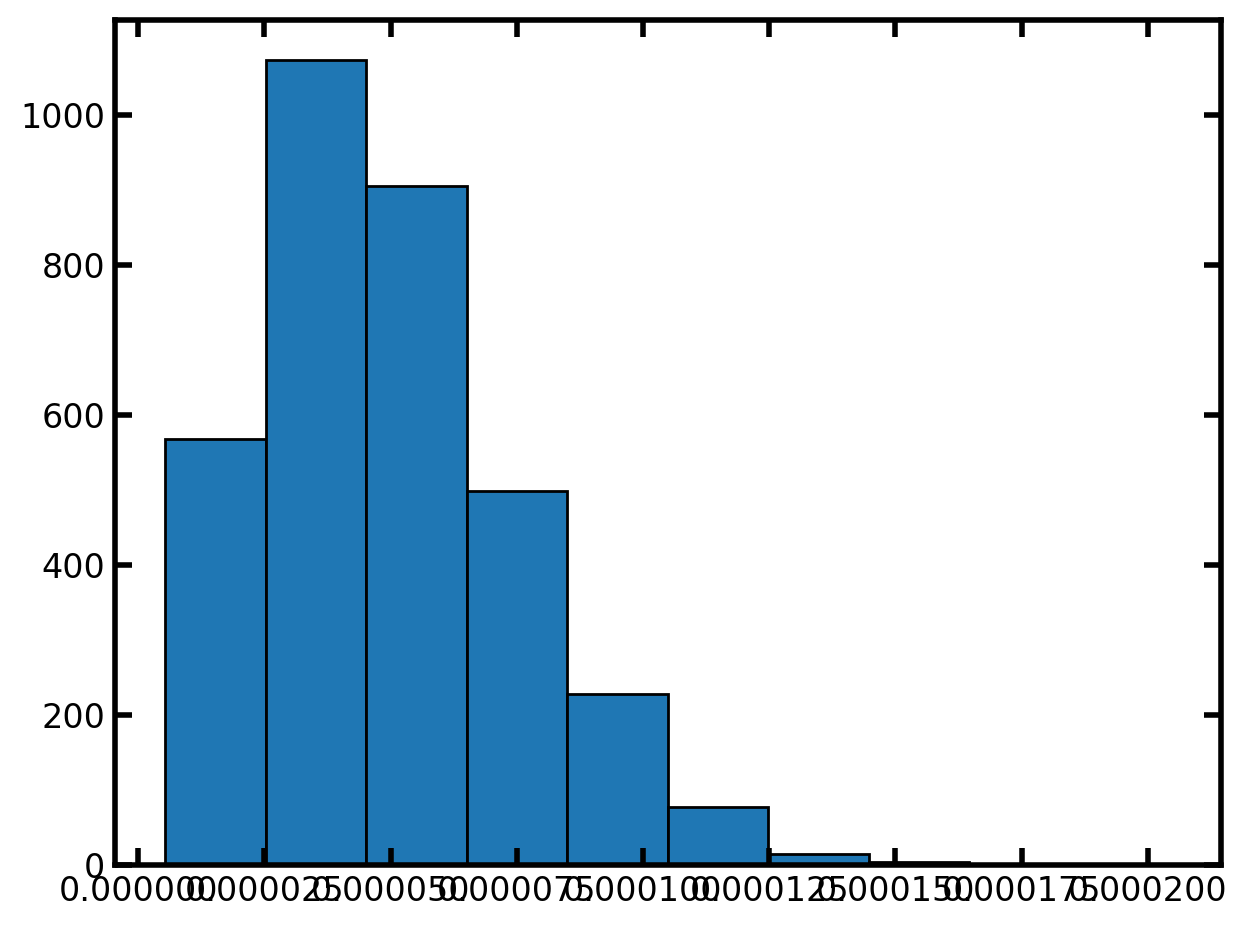

In [36]:
pn['pore.diameter'] = dst.rvs(pn.Np)
plt.hist(pn['pore.diameter'], edgecolor='k');

The problem with this approach is that when we change the pores sizes none of the other network properties will update automatically.  Since we will need to 'iterate' the pore size distribution many times to find the correct values, we will want things to update automatically.  

Therefore we need to assign the statistical model to the network as a pore scale model. OpenPNM includes a `generic_distribution` function, which accepts a pre-initialized `scipy.stats` distribution, like the one we defined above.  Let's run this model and confirm it works as expected:

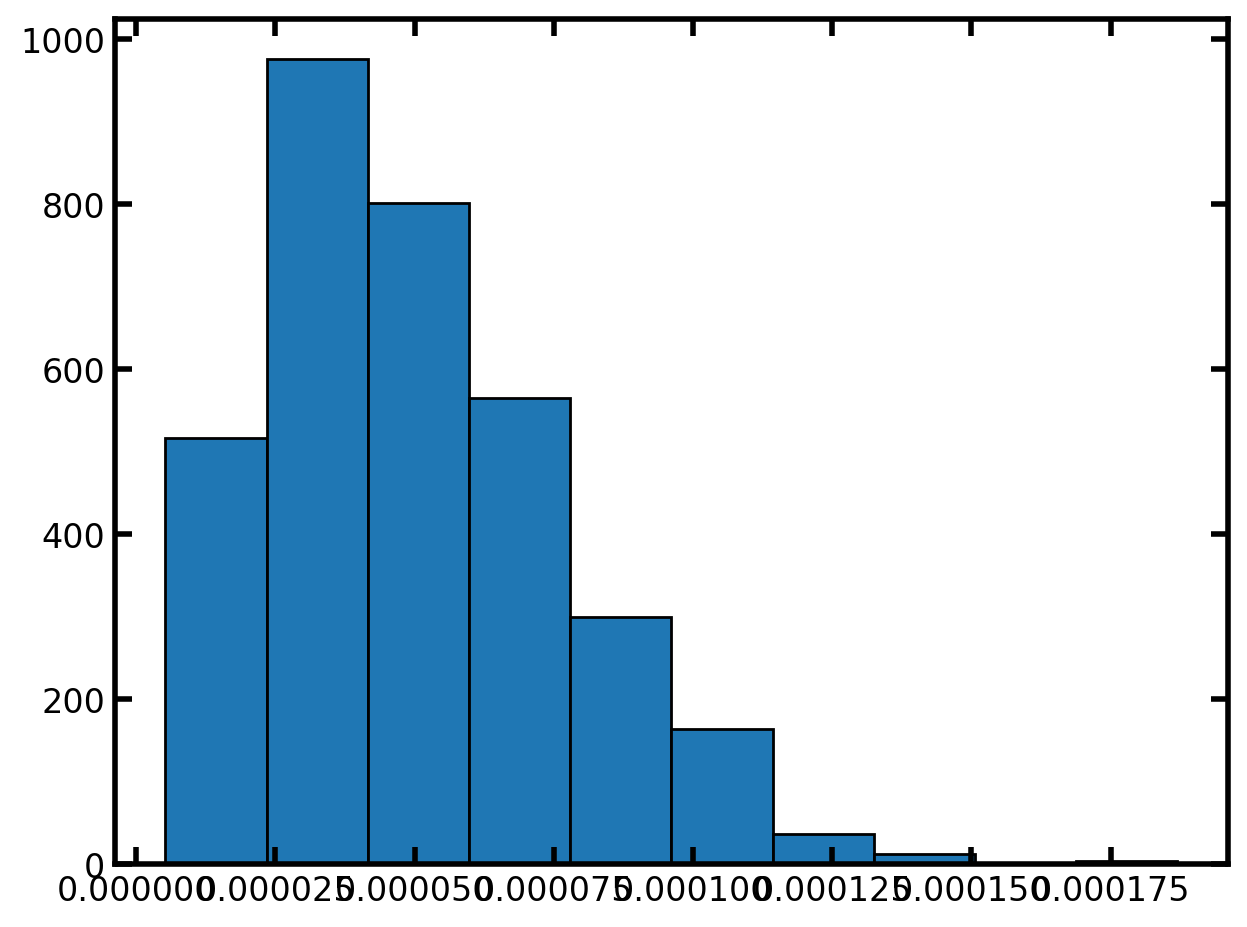

In [39]:
f = op.models.geometry.pore_size.generic_distribution(network=pn, func=dst, seeds='pore.seed')
plt.hist(f, edgecolor='k');

Now we will add it to the network in the "official" way:

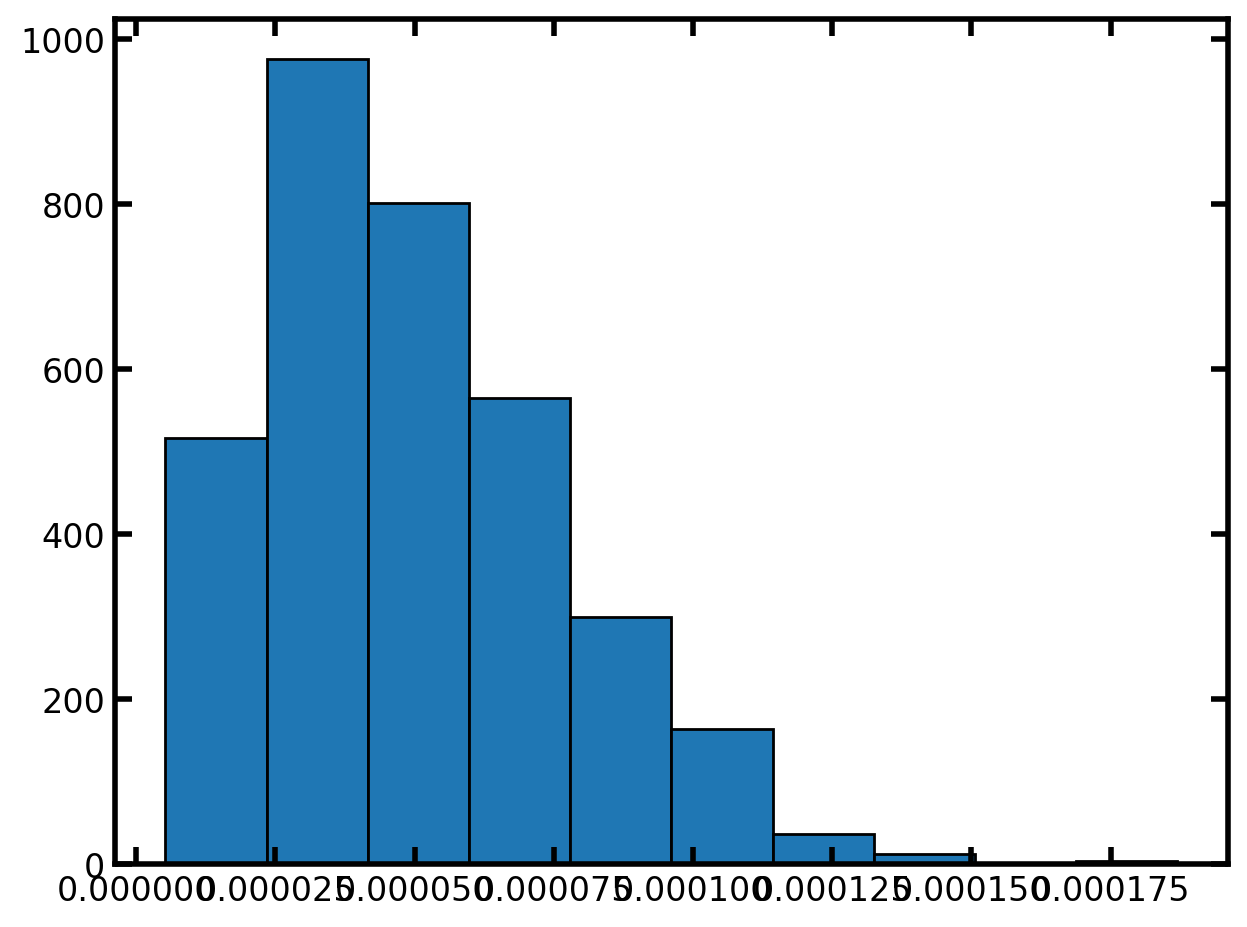

In [40]:
pn.add_model(propname='pore.diameter',
             model=op.models.geometry.pore_size.generic_distribution,
             func=dst,
             seeds='pore.seed')
pn.regenerate_models()
plt.hist(pn['pore.diameter'], edgecolor='k');

### Throat Sizes

When assigning throat sizes it must be remembered that throat sizes should *usually* be smaller than the two pores which they connects.  This is not *strictly* necessary, but it is consistent with the general picture of a porous material, and it also make other calculations quite a bit simpler. 

There are two methods we can use to assign throat sizes. We can assume that each throat is smaller than the two pores it connects by some factor, i.e., `0.25 * min(d1, d2)`.  Alternatively, we can assign each throat a `seed` value, which is taken as the minimum of the seed value in the two pores it connects, then use those values in any desired size distribution (which should produce smaller values than the chosen pore size distribution given the same seed values).

## Phase

Next we create a phase object which contains the thermophysical properties of the invading fluid, such as surface tension. In the case of mercury intrusion, the invading fluid is of course mercury!

In [4]:
hg = op.phase.Mercury(network=net, name='mercury')

## Add Physics

To simulate mercury intrusion, we will need to calulate the capillary pressure of the throats in the network. The capillary pressure can be calculated using the Washburn equation as provided below.

$$ P_C = \frac{-2\sigma cos(\theta)}{R_T} $$

The `basic` collection of physics model already contains the washburn model for capillary pressure so we will add it to the mercury phase object.

In [5]:
phys = op.models.collections.physics.basic
hg.add_model_collection(phys)
hg.regenerate_models()

------------------------------------------------------------
  - WARNING: throat.diffusive_conductance was not run since the following property is missing: 'throat.diffusivity' 
  - SOURCE : openpnm.core._models.regenerate_models 
  - TIME   : 2022-09-20 13:21:45,993    
------------------------------------------------------------


The washburn model will fetch the surface tension and contact angle from the mercury phase object while the throat radius is fetched from the network object. 

## Perform Mercury Intrusion

Now that all the required objects and models are setup, we can perform the capillary pressure curve simulation.  OpenPNM contains both InvasionPercolation and OrdinaryPercolation classes. The porosimetry experiment is ordinary percolation with access limitations. This means that a fixed pressure is applied to the invading fluid and all pores and throats that can be penetrated at that pressure are set as *possibly* invaded, *then* pores and throats are set to invaded only if they are physically connected to the source of invading fluid directly or though a path of already invading pores and throats.  

In [8]:
mip = op.algorithms.Drainage(network=net, phase=hg)
mip.set_inlet_BC(pores=net.pores('front'))
mip.run()

Performing drainage simulation: 100%|█████████████████████████████████████████████████| 25/25 [00:00<00:00, 128.02it/s]


The meaning of this warning message will be analyzed below, but first let's take a quick look at the result using the built-in plotting method:

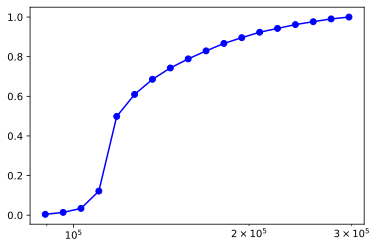

In [14]:
pc = mip.pc_curve()
plt.semilogx(*pc, 'b-o');